In [195]:
# Developed by: Ranjeet Kumar & Victor M. Zavala
# Implementation of scenario-based extensive form model for two-stage stochastic programming
# A 24-hour battery charge-discharge planning problem to minimize energy cost and demand charge
# UW-Madison, 2017

if (!isdefined(:JuMP)) using JuMP end
if (!isdefined(:Ipopt)) using Ipopt end
if (!isdefined(:PyPlot)) using PyPlot end

# construct scenario tree
nhours = 24;   # Number of hours we will plan the policy for
T = 24;        # Number of stages
dT = nhours/T; # Hours per stage
NS = 3;        # Number of scenarios of loads at each stage
Scens = 1:NS;      # Scenario set per stage
Stages = 1:T;  # Set of stages

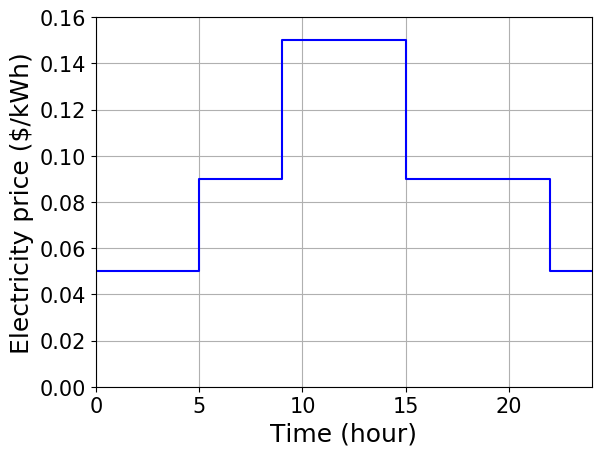

In [196]:
# Battery model Parameters
ebat_max = 500;	            # Battery capacity, kWh
P_max = 250;	            # Maximum power, kW
ebat0 = ebat_max;		    # Initial State of charge
rampmin = -0.5*P_max;	    # Lower bound for ramp discharge, kW/hr
rampmax = 0.5*P_max;  	    # Upper bound for ramp discharge, kW/hr
terminalSOC = ebat_max; # Terminal condition on SOC (at the end of day)
demandrate = 4.15           # demand charge over horizon $/kW

# Electricity Price data
eprice = [0.05 0.05 0.05 0.05 0.05 0.09 0.09 0.09 0.09 0.15 0.15 0.15 0.15 0.15 0.15 0.09 0.09 0.09 0.09 0.09 0.09 0.09 0.05 0.05];

# Plot to visualize load profile scenarios
figure()
grid()
plot(0:nhours, push!(eprice[1,:], eprice[1,end]), drawstyle="steps-post", color="blue", linewidth=1.5) 
xlim(0,nhours)
ylim(0,0.16)
xlabel("Time (hour)", size=18)
ylabel("Electricity price (\$/kWh)", size=18)
tick_params(labelsize=15)
savefig("energy_price_profile.pdf")

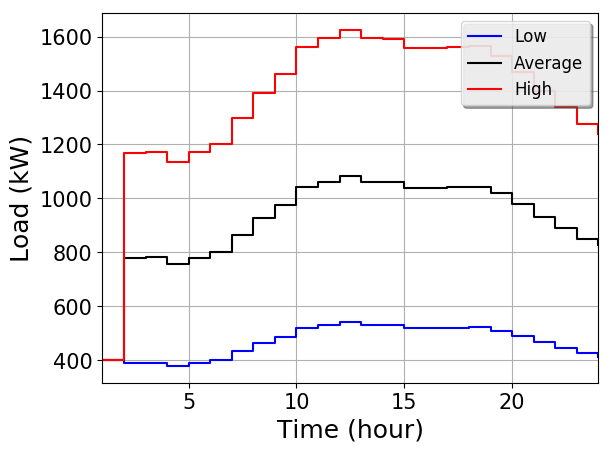

In [197]:
# Hourly load data
meanload = [803.689 779.355 781.096 757.36 780.282 801.882 865.736 927.623 974.548 1041.19 1062.17 1083.26 1062.25 1061.99 1038.16 1039.47 1040.53 1042.99 1018.81 978.295 932.221 892.035 849.88 826.602];
load_scens = [0.50*meanload' meanload' 1.50*meanload']; # three scenarios of load profile: low, average and high

# Assume first load is known
for s in 1:NS
  load_scens[1,s] = load_scens[1,1];
end

# plot time profiles load
figure()
hold(true)
grid()
plot(1:dT:nhours, load_scens[:,1], drawstyle="steps-post", color="blue", linewidth=1.5, label="Low")
plot(1:dT:nhours, load_scens[:,2], drawstyle="steps-post", color="black", linewidth=1.5, label="Average")
plot(1:dT:nhours, load_scens[:,3], drawstyle="steps-post", color="red", linewidth=1.5, label="High")
xlim(1,nhours)
xlabel("Time (hour)", size=18)
ylabel("Load (kW)", size=18)
tick_params(labelsize=15)
legend(loc="upper right",fancybox="True", shadow="True", fontsize = 12)
savefig("load_profile_scenarios.pdf")

In [198]:
######################################################
# Two-Stage Stochastic Programming Model

m = Model(solver = IpoptSolver(print_level=0))
@variable(m, 0 <= ebat[Stages,Scens] <= ebat_max) # Energy level of battery (SOC) at stage t
@variable(m, -P_max <= P[Stages,Scens] <= P_max)# Net power (discharging is positive, charging is negative) at stage t
@variable(m, d[Stages,Scens] >= 0) # Unmet load at stage t
@variable(m, D[Scens])
@variable(m, energycost[Scens])
@variable(m, demandcost[Scens])

@objective(m, Min, sum(energycost[s]+demandcost[s] for s in Scens))
# Inital SOC of battery in all scenarios is ebat0
@constraint(m, EnergyBalance[t in Stages[1:end-1], s in Scens], ebat[t+1,s] == ebat[t,s] - P[t,s]*dT)
# Terminal condition
@constraint(m, TerminalSOC[t in Stages[end], s in Scens], ebat[t,s] >= terminalSOC)
# Power required to be purchased from grid = d[t,s]
@constraint(m, DemandfromGrid[t in Stages, s in Scens], P[t,s] + d[t,s] == load_scens[t,s])
# Demand charge
@constraint(m, DemandCharge[s in Scens, t in Stages], D[s] >= d[t,s])
# Energy Cost calculation for each scenario
@constraint(m, EnergyCost[s in Scens], energycost[s] == sum((1/NS)*eprice[t]*d[t,s]*dT for t in Stages))
# Demand charge cost calculation for each scenario
@constraint(m, DemandCost[s in Scens], demandcost[s] == demandrate*D[s])

# Nonanticipativity: Decisions have to be same in all scenarios in the set S(n) [getLeafs(n)]
@constraint(m, Nonanticipativity[t in Stages[1:3],s in Scens], P[t,s] == P[t,1])
                        
status = solve(m)

:Optimal

In [199]:
# collect results
ebat = Matrix(T,NS)
P = Matrix(T,NS)
d = Matrix(T,NS)
D = Vector(NS)
energycost = Vector(NS)
demandcost = Vector(NS)

for t in 1:T
  ss = 1;
  for s in Scens
    ebat[t,ss] = getvalue(getvariable(m,:ebat)[t,s]);
    P[t,ss] = getvalue(getvariable(m,:P)[t,s]);
    d[t,ss] = getvalue(getvariable(m,:d)[t,s]);
    ss = ss + 1;
  end
end

ss = 1;
for s in Scens
	D[ss] = getvalue(getvariable(m,:D)[s])
  energycost[ss] = getvalue(getvariable(m,:energycost)[s]);
  demandcost[ss] = getvalue(getvariable(m,:demandcost)[s]);
  ss = ss + 1;
end
obj_val = getobjectivevalue(m);

println("Expected total cost = $(obj_val)")

Expected total cost = 14733.888490654055


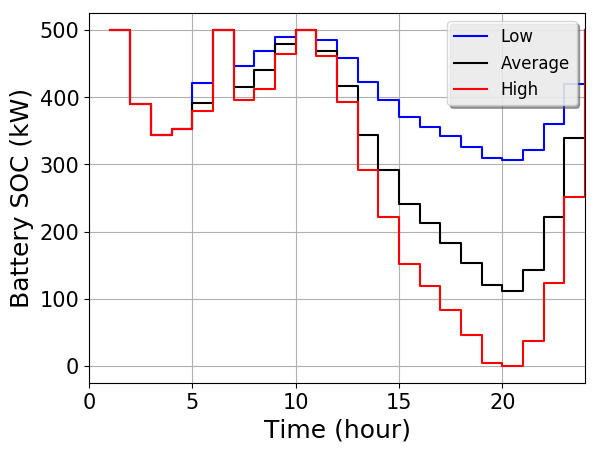

In [200]:
# plot state tree pathways
figure()
grid()
plot(1:dT:nhours, ebat[:,1], drawstyle="steps-post", color="blue", linewidth=1.5, label="Low")
plot(1:dT:nhours, ebat[:,2], drawstyle="steps-post", color="black", linewidth=1.5, label="Average")
plot(1:dT:nhours, ebat[:,3], drawstyle="steps-post", color="red", linewidth=1.5, label="High")
xlabel("Time (hour)", size=18)
ylabel("Battery SOC (kW)", size=18)
xlim(0,24)
tick_params(labelsize=15)
legend(loc="upper right",fancybox="True", shadow="True", fontsize = 12)
savefig("state_profile_tree.pdf")

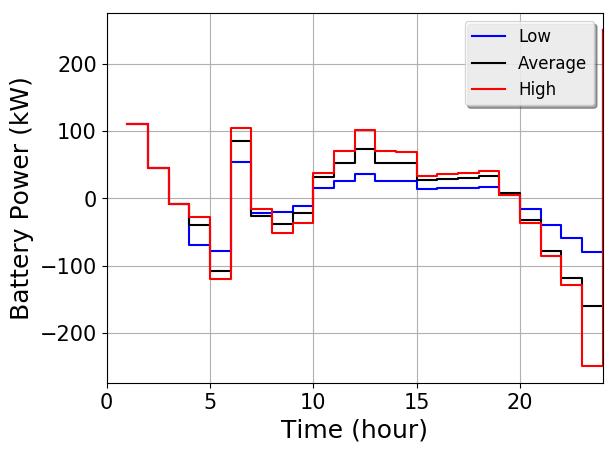

In [201]:
# plot control tree pathways
figure()
grid()
plot(1:dT:nhours, P[:,1], drawstyle="steps-post", color="blue", linewidth=1.5, label="Low")
plot(1:dT:nhours, P[:,2], drawstyle="steps-post", color="black", linewidth=1.5, label="Average")
plot(1:dT:nhours, P[:,3], drawstyle="steps-post", color="red", linewidth=1.5, label="High")
xlabel("Time (hour)", size=18)
ylabel("Battery Power (kW)", size=18)
xlim(0,24)
tick_params(labelsize=15)
legend(loc="upper right",fancybox="True", shadow="True", fontsize = 12)
savefig("control_profile_tree.pdf")

In [202]:
print(P)

Any[110.909 110.909 110.909; 45.5184 45.5184 45.5184; -8.63212 -8.63212 -8.63212; -69.2385 -39.2576 -27.6462; -78.5565 -108.537 -120.149; 53.2428 85.5528 103.83; -21.5879 -26.2183 -15.9985; -20.9286 -38.2591 -51.8951; -10.7263 -21.0754 -35.9362; 15.4789 30.9578 38.162; 25.9689 51.9378 69.632; 36.5139 73.0278 101.267; 26.0089 52.0178 69.752; 25.8789 51.7578 69.362; 13.9639 27.9278 33.617; 14.6189 29.2378 35.582; 15.1489 30.2978 37.172; 16.3789 32.7578 40.862; 4.28889 8.57779 4.592; -15.9686 -31.9372 -37.0049; -39.0056 -78.0112 -85.9042; -59.0986 -118.197 -128.288; -80.1761 -160.352 -248.803; 250.0 250.0 250.0]